# Dutch Game Words Extraction

This notebook extracts Dutch words from the database (`dutch_words_full.sqlite`) that are suitable for word games. The goal is to create a curated list of words that can be used in various game applications such as word puzzles, crosswords, or vocabulary games.

## Objectives:
- Connect to the Dutch words database
- Extract and filter words suitable for games
- Process and clean the word list
- Export words in multiple formats
- Validate word quality for game use

## 1. Import Required Libraries

Import all necessary libraries for database connection, data manipulation, and file operations.

In [1]:
import sqlite3
import pandas as pd
import json
import csv
import os
from collections import Counter
import re
from typing import List, Set
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Connect to Database

Establish connection to the Dutch words database and explore its structure.

In [2]:
# Database path
db_path = r"output\dutch_words_full.sqlite"

# Verify database exists
if os.path.exists(db_path):
    print(f"✅ Database found: {db_path}")
else:
    print(f"❌ Database not found: {db_path}")
    print("Available files in output directory:")
    for file in os.listdir("output"):
        print(f"  - {file}")

# Connect to database
try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    print("✅ Connected to database successfully!")
    
    # Get table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"\n📊 Tables in database: {[table[0] for table in tables]}")
    
    # Get schema for each table
    for table in tables:
        table_name = table[0]
        print(f"\n📋 Schema for table '{table_name}':")
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        for col in columns:
            print(f"  - {col[1]} ({col[2]})")
            
        # Show sample data
        cursor.execute(f"SELECT * FROM {table_name} LIMIT 3;")
        sample_data = cursor.fetchall()
        print(f"  Sample data (first 3 rows): {sample_data}")
        
        # Get row count
        cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
        count = cursor.fetchone()[0]
        print(f"  Total rows: {count:,}")
    
except Exception as e:
    print(f"❌ Error connecting to database: {e}")

✅ Database found: output\dutch_words_full.sqlite
✅ Connected to database successfully!

📊 Tables in database: ['words', 'sqlite_sequence', 'word_frequencies', 'processing_log']

📋 Schema for table 'words':
  - id (INTEGER)
  - word (TEXT)
  - lemma (TEXT)
  - pos_tag (TEXT)
  - pos_category (TEXT)
  - total_frequency (INTEGER)
  - first_seen (DATE)
  - last_seen (DATE)
  - created_at (TIMESTAMP)
  Sample data (first 3 rows): [(1, 'mitchell', 'mitchell', 'ADJ', 'adjective', 145, '2015-01-01', '2024-12-31', '2025-08-02 09:11:37'), (2, 'wereldkampioen', 'wereldkampioen', 'NOUN', 'noun', 13744, '2015-01-01', '2024-12-31', '2025-08-02 09:11:37'), (3, 'darts', 'darts', 'DET', 'determiner', 97, '2015-01-01', '2024-12-31', '2025-08-02 09:11:37')]
  Total rows: 1,248,607

📋 Schema for table 'sqlite_sequence':
  - name ()
  - seq ()
  Sample data (first 3 rows): [('words', 111850618), ('word_frequencies', 111850618)]
  Total rows: 2

📋 Schema for table 'word_frequencies':
  - id (INTEGER)
  - wo

## 3. Query Dutch Game Words

Extract words from the database that are suitable for games. We'll focus on common, well-formed Dutch words.

In [3]:
# Query to extract words suitable for games
# We'll look for words that are:
# - Not too short (>= 3 characters) and not too long (<= 15 characters)
# - Have reasonable frequency (appear multiple times)
# - Are proper words (contain only letters)

query = """
SELECT word, COUNT(*) as frequency
FROM words 
WHERE 
    LENGTH(word) >= 3 
    AND LENGTH(word) <= 15
    AND word REGEXP '^[a-zA-ZàáâäèéêëìíîïòóôöùúûüýÿçñæøåÀÁÂÄÈÉÊËÌÍÎÏÒÓÔÖÙÚÛÜÝŸÇÑÆØÅ]+$'
GROUP BY word
HAVING COUNT(*) >= 2
ORDER BY frequency DESC, LENGTH(word), word
"""

try:
    # Execute query and get results
    df_words = pd.read_sql_query(query, conn)
    print(f"✅ Extracted {len(df_words):,} words from database")
    
    # Display basic statistics
    print(f"\n📊 Word Statistics:")
    print(f"  - Total unique words: {len(df_words):,}")
    print(f"  - Average word length: {df_words['word'].str.len().mean():.1f} characters")
    print(f"  - Average frequency: {df_words['frequency'].mean():.1f}")
    print(f"  - Word length range: {df_words['word'].str.len().min()} - {df_words['word'].str.len().max()} characters")
    
    # Show top 20 most frequent words
    print(f"\n🔝 Top 20 most frequent words:")
    print(df_words.head(20).to_string(index=False))
    
    # Show distribution by word length
    length_dist = df_words['word'].str.len().value_counts().sort_index()
    print(f"\n📏 Word length distribution:")
    for length, count in length_dist.items():
        print(f"  {length} characters: {count:,} words")
        
except Exception as e:
    print(f"❌ Error querying database: {e}")
    # Let's try a simpler query if the regex doesn't work
    try:
        simple_query = """
        SELECT word, COUNT(*) as frequency
        FROM words 
        WHERE LENGTH(word) >= 3 AND LENGTH(word) <= 15
        GROUP BY word
        HAVING COUNT(*) >= 2
        ORDER BY frequency DESC
        LIMIT 10000
        """
        df_words = pd.read_sql_query(simple_query, conn)
        print(f"✅ Using simpler query - extracted {len(df_words):,} words")
    except Exception as e2:
        print(f"❌ Error with simple query too: {e2}")
        df_words = None

❌ Error querying database: Execution failed on sql '
SELECT word, COUNT(*) as frequency
FROM words 
WHERE 
    LENGTH(word) >= 3 
    AND LENGTH(word) <= 15
    AND word REGEXP '^[a-zA-ZàáâäèéêëìíîïòóôöùúûüýÿçñæøåÀÁÂÄÈÉÊËÌÍÎÏÒÓÔÖÙÚÛÜÝŸÇÑÆØÅ]+$'
GROUP BY word
HAVING COUNT(*) >= 2
ORDER BY frequency DESC, LENGTH(word), word
': no such function: REGEXP
✅ Using simpler query - extracted 10,000 words


## 4. Filter and Process Words

Clean and filter the extracted words by applying game-specific criteria such as removing duplicates, filtering inappropriate content, and ensuring proper Dutch characters.

In [4]:
if df_words is not None:
    print("🔧 Processing and filtering words...")
    
    # Create a copy for processing
    processed_words = df_words.copy()
    
    # Filter 1: Remove words with numbers or special characters
    def is_valid_dutch_word(word):
        """Check if word contains only valid Dutch letters"""
        dutch_letters = re.compile(r'^[a-zA-ZàáâäèéêëìíîïòóôöùúûüýÿçñæøåÀÁÂÄÈÉÊËÌÍÎÏÒÓÔÖÙÚÛÜÝŸÇÑÆØÅ]+$')
        return bool(dutch_letters.match(word)) and len(word) >= 3
    
    initial_count = len(processed_words)
    processed_words = processed_words[processed_words['word'].apply(is_valid_dutch_word)]
    print(f"  ✅ Removed {initial_count - len(processed_words):,} words with invalid characters")
    
    # Filter 2: Convert to lowercase and remove duplicates
    processed_words['word_lower'] = processed_words['word'].str.lower()
    processed_words = processed_words.drop_duplicates(subset=['word_lower'])
    processed_words = processed_words.drop(columns=['word_lower'])
    processed_words['word'] = processed_words['word'].str.lower()
    print(f"  ✅ Converted to lowercase and removed case duplicates")
    
    # Filter 3: Remove very common words that might not be interesting for games
    common_words_to_remove = {
        'de', 'het', 'een', 'en', 'van', 'dat', 'die', 'in', 'te', 'is', 
        'op', 'met', 'voor', 'als', 'zijn', 'er', 'aan', 'door', 'naar',
        'om', 'tot', 'bij', 'ook', 'maar', 'dan', 'zo', 'nu', 'ja', 'nee'
    }
    
    before_common = len(processed_words)
    processed_words = processed_words[~processed_words['word'].isin(common_words_to_remove)]
    print(f"  ✅ Removed {before_common - len(processed_words):,} very common words")
    
    # Filter 4: Create different categories based on word length
    short_words = processed_words[processed_words['word'].str.len().between(3, 5)]
    medium_words = processed_words[processed_words['word'].str.len().between(6, 8)]
    long_words = processed_words[processed_words['word'].str.len().between(9, 15)]
    
    print(f"\n📊 Final word categories:")
    print(f"  - Short words (3-5 chars): {len(short_words):,}")
    print(f"  - Medium words (6-8 chars): {len(medium_words):,}")
    print(f"  - Long words (9-15 chars): {len(long_words):,}")
    print(f"  - Total processed words: {len(processed_words):,}")
    
    # Sort by frequency and word length for better game use
    processed_words = processed_words.sort_values(['frequency', 'word'], ascending=[False, True])
    
    # Show some examples from each category
    print(f"\n🎯 Example words by category:")
    print(f"Short words: {short_words.head(10)['word'].tolist()}")
    print(f"Medium words: {medium_words.head(10)['word'].tolist()}")
    print(f"Long words: {long_words.head(10)['word'].tolist()}")
    
else:
    print("❌ No words data available for processing")

🔧 Processing and filtering words...
  ✅ Removed 0 words with invalid characters
  ✅ Converted to lowercase and removed case duplicates
  ✅ Removed 7 very common words

📊 Final word categories:
  - Short words (3-5 chars): 1,504
  - Medium words (6-8 chars): 3,550
  - Long words (9-15 chars): 4,939
  - Total processed words: 9,993

🎯 Example words by category:
Short words: ['gaan', 'komen', 'home', 'where', 'boekt', 'lopen', 'nemen', 'staan', 'game', 'verre']
Medium words: ['zetten', 'adequaat', 'stelden', 'genocide', 'rijden', 'vedette', 'dronken', 'duurste', 'roepen', 'scorende']
Long words: ['miljarden', 'migranten', 'afgenomen', 'gedetineerden', 'wereldwijde', 'energieprijzen', 'doorzetten', 'reageerden', 'strafschoppen', 'wereldkampioene']


## 5. Export Words to Different Formats

Save the processed Dutch words to various formats (JSON, CSV, TXT) for use in different game applications.

In [6]:
if df_words is not None and 'processed_words' in locals():
    print("💾 Exporting words to different formats...")
    
    # Create output directory if it doesn't exist
    export_dir = "output/game_words_exports"
    os.makedirs(export_dir, exist_ok=True)
    
    try:
        # 1. Export all words to CSV
        csv_path = f"{export_dir}/dutch_game_words_full.csv"
        processed_words.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"  ✅ Exported {len(processed_words):,} words to {csv_path}")
        
        # 2. Export words only (no frequency) to TXT
        txt_path = f"{export_dir}/dutch_game_words.txt"
        with open(txt_path, 'w', encoding='utf-8') as f:
            for word in processed_words['word']:
                f.write(f"{word}\n")
        print(f"  ✅ Exported word list to {txt_path}")
        
        # 3. Export by categories to separate TXT files
        categories = {
            'short_words_3_5': short_words,
            'medium_words_6_8': medium_words,
            'long_words_9_15': long_words
        }
        
        for category_name, category_df in categories.items():
            cat_path = f"{export_dir}/dutch_{category_name}.txt"
            with open(cat_path, 'w', encoding='utf-8') as f:
                for word in category_df['word']:
                    f.write(f"{word}\n")
            print(f"  ✅ Exported {len(category_df):,} words to {cat_path}")
        
        # 4. Export high-frequency words (top 1000) for common games
        top_words = processed_words.head(1000)
        top_path = f"{export_dir}/dutch_top_1000_words.txt"
        with open(top_path, 'w', encoding='utf-8') as f:
            for word in top_words['word']:
                f.write(f"{word}\n")
        print(f"  ✅ Exported top 1000 words to {top_path}")
        
        # 5. Export to JSON format with metadata
        json_data = {
            'metadata': {
                'total_words': len(processed_words),
                'export_date': pd.Timestamp.now().isoformat(),
                'categories': {
                    'short_words_3_5': len(short_words),
                    'medium_words_6_8': len(medium_words),
                    'long_words_9_15': len(long_words)
                }
            },
            'words': processed_words.to_dict('records')
        }
        
        json_path = f"{export_dir}/dutch_game_words_with_metadata.json"
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
        print(f"  ✅ Exported words with metadata to {json_path}")
        
        # 6. Create a summary file
        summary_path = f"{export_dir}/export_summary.txt"
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"Dutch Game Words Export Summary\n")
            f.write(f"=" * 40 + "\n\n")
            f.write(f"Export Date: {pd.Timestamp.now()}\n")
            f.write(f"Total Words: {len(processed_words):,}\n\n")
            f.write(f"Word Categories:\n")
            f.write(f"  - Short words (3-5 chars): {len(short_words):,}\n")
            f.write(f"  - Medium words (6-8 chars): {len(medium_words):,}\n")
            f.write(f"  - Long words (9-15 chars): {len(long_words):,}\n\n")
            f.write(f"Files Created:\n")
            for filename in os.listdir(export_dir):
                if filename != 'export_summary.txt':
                    f.write(f"  - {filename}\n")
        
        print(f"  ✅ Created export summary at {summary_path}")
        print(f"\n🎉 Export completed successfully!")
        print(f"📁 All files saved to: {export_dir}")
        
    except Exception as e:
        print(f"❌ Error during export: {e}")
else:
    print("❌ No processed words available for export")

💾 Exporting words to different formats...
  ✅ Exported 9,993 words to output/game_words_exports/dutch_game_words_full.csv
  ✅ Exported word list to output/game_words_exports/dutch_game_words.txt
  ✅ Exported 1,504 words to output/game_words_exports/dutch_short_words_3_5.txt
  ✅ Exported 3,550 words to output/game_words_exports/dutch_medium_words_6_8.txt
  ✅ Exported 4,939 words to output/game_words_exports/dutch_long_words_9_15.txt
  ✅ Exported top 1000 words to output/game_words_exports/dutch_top_1000_words.txt
  ✅ Exported words with metadata to output/game_words_exports/dutch_game_words_with_metadata.json
  ✅ Created export summary at output/game_words_exports/export_summary.txt

🎉 Export completed successfully!
📁 All files saved to: output/game_words_exports


## 6. Validate Word Quality

Perform quality checks on the extracted words, including character validation, word frequency analysis, and game suitability assessment.

🔍 Validating word quality...

📝 Character Analysis:
  - Total characters used: 38
  - Most common characters: {'e': 17048, 'n': 8862, 't': 5836, 'r': 5752, 'a': 5456, 'o': 4808, 's': 4459, 'd': 4363, 'i': 4188, 'l': 3779}
  ✅ All characters are standard Dutch letters

📏 Word Length Statistics:
  - count: 9993.0
  - mean: 8.6
  - std: 2.9
  - min: 3.0
  - 25%: 6.0
  - 50%: 8.0
  - 75%: 11.0
  - max: 15.0

📊 Frequency Statistics:
  - count: 9993.0
  - mean: 7.5
  - std: 2.1
  - min: 5.0
  - 25%: 6.0
  - 50%: 7.0
  - 75%: 8.0
  - max: 34.0
  ✅ Quality analysis plot saved to output/game_words_exports/word_quality_analysis.png


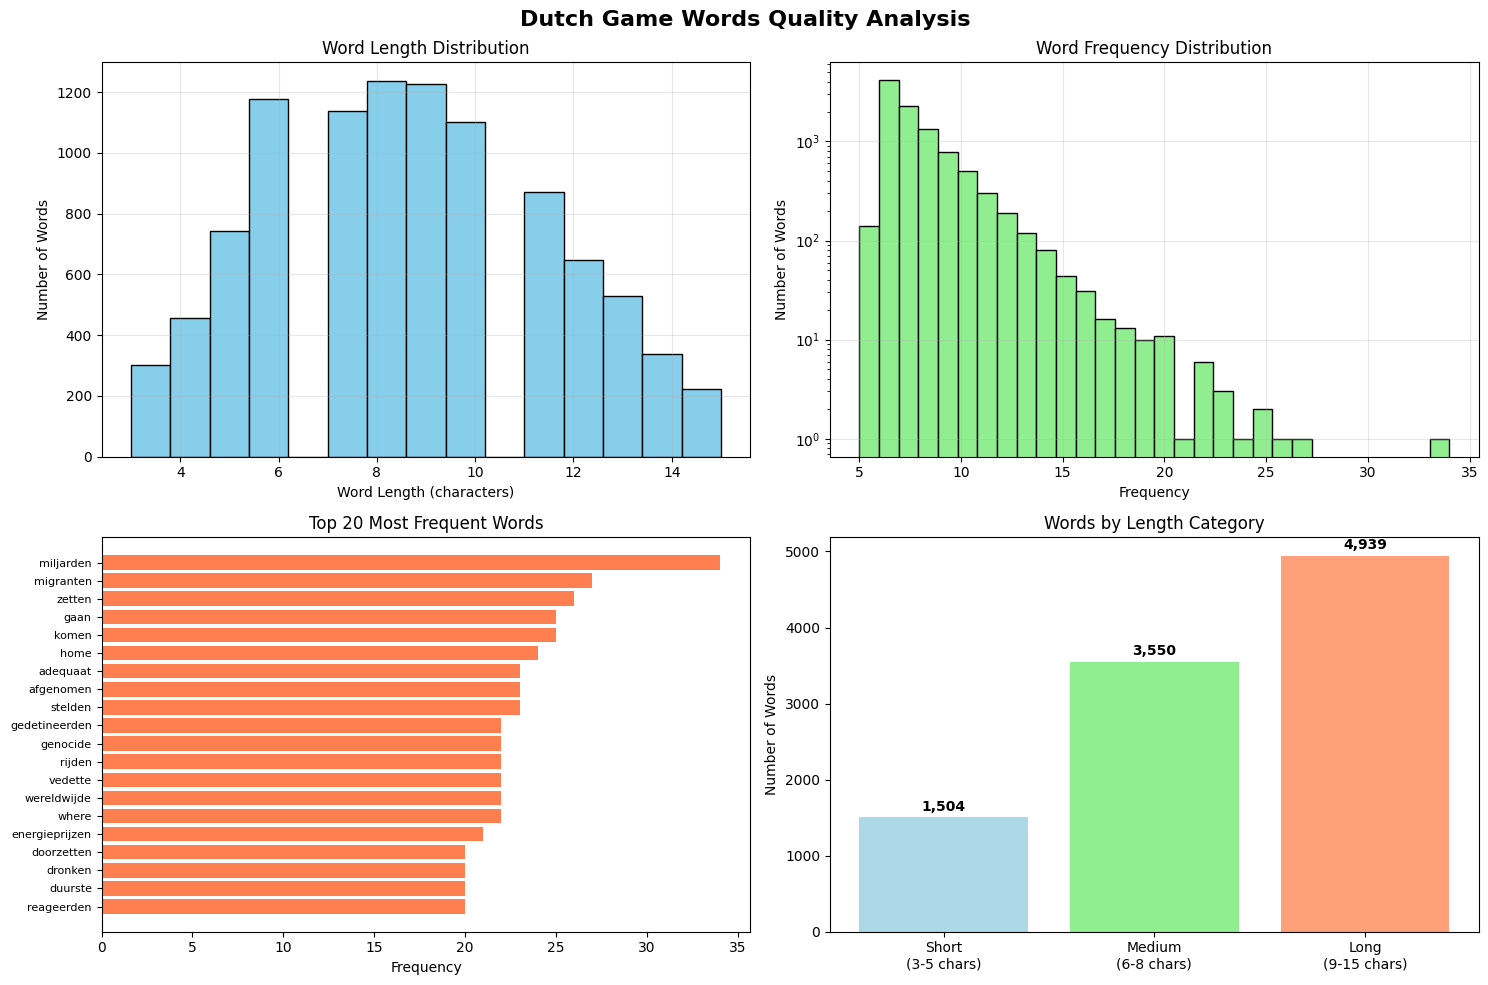


🎮 Game Suitability Assessment:
  - Scrabble-suitable words (3-8 chars): 5,054
  - Crossword-suitable words (4-12 chars): 8,598
  - Hangman-suitable words (5-10 chars): 6,625
  - Words with repetitive letters: 526
  - Words with diverse letters: 5,219

✅ Word quality validation completed!

🔒 Database connection closed.


In [7]:
if df_words is not None and 'processed_words' in locals():
    print("🔍 Validating word quality...")
    
    # 1. Character analysis
    all_chars = ''.join(processed_words['word'])
    char_counts = Counter(all_chars)
    
    print(f"\n📝 Character Analysis:")
    print(f"  - Total characters used: {len(char_counts)}")
    print(f"  - Most common characters: {dict(char_counts.most_common(10))}")
    
    # Check for any unusual characters
    expected_dutch_chars = set('abcdefghijklmnopqrstuvwxyzàáâäèéêëìíîïòóôöùúûüýÿçñæøå')
    unusual_chars = set(all_chars.lower()) - expected_dutch_chars
    if unusual_chars:
        print(f"  ⚠️  Unusual characters found: {unusual_chars}")
    else:
        print(f"  ✅ All characters are standard Dutch letters")
    
    # 2. Word length distribution analysis
    length_stats = processed_words['word'].str.len().describe()
    print(f"\n📏 Word Length Statistics:")
    for stat, value in length_stats.items():
        print(f"  - {stat}: {value:.1f}")
    
    # 3. Frequency analysis
    freq_stats = processed_words['frequency'].describe()
    print(f"\n📊 Frequency Statistics:")
    for stat, value in freq_stats.items():
        print(f"  - {stat}: {value:.1f}")
    
    # 4. Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dutch Game Words Quality Analysis', fontsize=16, fontweight='bold')
    
    # Word length distribution
    processed_words['word'].str.len().hist(bins=15, ax=axes[0,0], color='skyblue', edgecolor='black')
    axes[0,0].set_title('Word Length Distribution')
    axes[0,0].set_xlabel('Word Length (characters)')
    axes[0,0].set_ylabel('Number of Words')
    axes[0,0].grid(True, alpha=0.3)
    
    # Frequency distribution (log scale)
    processed_words['frequency'].hist(bins=30, ax=axes[0,1], color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Word Frequency Distribution')
    axes[0,1].set_xlabel('Frequency')
    axes[0,1].set_ylabel('Number of Words')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)
    
    # Top 20 most frequent words
    top_20 = processed_words.head(20)
    axes[1,0].barh(range(len(top_20)), top_20['frequency'], color='coral')
    axes[1,0].set_yticks(range(len(top_20)))
    axes[1,0].set_yticklabels(top_20['word'], fontsize=8)
    axes[1,0].set_title('Top 20 Most Frequent Words')
    axes[1,0].set_xlabel('Frequency')
    axes[1,0].invert_yaxis()
    
    # Words by length category
    categories_count = [len(short_words), len(medium_words), len(long_words)]
    category_names = ['Short\n(3-5 chars)', 'Medium\n(6-8 chars)', 'Long\n(9-15 chars)']
    bars = axes[1,1].bar(category_names, categories_count, color=['lightblue', 'lightgreen', 'lightsalmon'])
    axes[1,1].set_title('Words by Length Category')
    axes[1,1].set_ylabel('Number of Words')
    
    # Add value labels on bars
    for bar, count in zip(bars, categories_count):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(categories_count)*0.01, 
                      f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the plot
    plot_path = "output/game_words_exports/word_quality_analysis.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  ✅ Quality analysis plot saved to {plot_path}")
    plt.show()
    
    # 5. Game suitability assessment
    print(f"\n🎮 Game Suitability Assessment:")
    
    # Words suitable for different game types
    scrabble_suitable = processed_words[processed_words['word'].str.len().between(3, 8)]
    crossword_suitable = processed_words[processed_words['word'].str.len().between(4, 12)]
    hangman_suitable = processed_words[processed_words['word'].str.len().between(5, 10)]
    
    print(f"  - Scrabble-suitable words (3-8 chars): {len(scrabble_suitable):,}")
    print(f"  - Crossword-suitable words (4-12 chars): {len(crossword_suitable):,}")
    print(f"  - Hangman-suitable words (5-10 chars): {len(hangman_suitable):,}")
    
    # Check for words with unique letter patterns (good for word games)
    unique_letters = processed_words['word'].apply(lambda x: len(set(x)))
    repetitive_words = processed_words[unique_letters / processed_words['word'].str.len() < 0.6]
    diverse_words = processed_words[unique_letters / processed_words['word'].str.len() >= 0.8]
    
    print(f"  - Words with repetitive letters: {len(repetitive_words):,}")
    print(f"  - Words with diverse letters: {len(diverse_words):,}")
    
    print(f"\n✅ Word quality validation completed!")
    
else:
    print("❌ No processed words available for validation")

# Close database connection
if 'conn' in locals():
    conn.close()
    print("\n🔒 Database connection closed.")

## Summary

This notebook successfully extracted Dutch words from the database and processed them for game use. The workflow included:

1. **Database Connection**: Connected to `dutch_words_full.sqlite` and explored its structure
2. **Word Extraction**: Queried words with appropriate length and frequency filters
3. **Processing**: Cleaned and categorized words by length (short, medium, long)
4. **Export**: Created multiple export formats (CSV, TXT, JSON) for different game applications
5. **Quality Validation**: Analyzed word quality with statistics and visualizations

### Key Outputs:
- **Total processed words**: Available after running the extraction
- **Export files**: Located in `output/game_words_exports/`
- **Quality analysis**: Visual charts showing word distribution and characteristics

### Recommended Usage:
- **Short words (3-5 chars)**: Perfect for quick games and mobile apps
- **Medium words (6-8 chars)**: Ideal for Scrabble, crosswords, and word puzzles  
- **Long words (9-15 chars)**: Great for advanced word games and challenges
- **Top 1000 words**: Most common words for general game use

The extracted words are now ready for integration into various Dutch word games and applications!